### Mike's Exploration of the ADH data...

This builds off of Spencer's replication. It cuts the data in a way that we can plot and understand what is going on...

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from linearmodels.iv import IV2SLS

fig_path = "C:\\Users\\mwaugh.NYC-STERN\\Documents\\GitHub\\tradeexposure\\figures"
# This is if I want to output the figure

This reads in the ADH dataset and then adds a constant.

In [2]:
df = pd.read_stata("workfile_china.dta")
df["const"] = 1

Then lets check out the var names.

In [42]:
var_names  = pd.DataFrame(df.columns)

var_names.to_excel("var_names.xlsx") # If you want to see what they are (like 200) this 
                                     # this is one way to do it...

regions = list(filter(lambda x: x.startswith("reg"), df.columns))
                                    # Spencer's way to figure out regional dummies.

df["dm_IPW"] = df.d_tradeusch_pw / df.l_tradeusch_pw.mean()
                                    # This is a normalization I'm going to explore
                                    # The one thing about this is it is off the change, not the level...
                                    # This, thus, could be zero in the model.
            
df.dm_IPW.describe()

count    1444.000000
mean        2.563107
std         3.474257
min        -0.845970
25%         0.583738
50%         1.585851
75%         3.344456
max        57.950295
Name: dm_IPW, dtype: float64

This last bit takes the IPW measure and then divides by the mean. The idea here is to get things out of dollars and into a unit that we can better understand. 

#### Summary statistics about trade exposure. 

The first one reports the mean change in trade exposure.

In [47]:
years  = [1990, 2000]
sum_stats_dm = []
sum_stats = []

for var in years:

    sum_stats.append(round(df.set_index("yr").loc[var].d_tradeusch_pw.median(),2))
    sum_stats_dm.append(round(df.set_index("yr").loc[var].dm_IPW.mean(),2))    
    
print("Change in Import Exposure ($)", sum_stats)
print("Change in Import Exposure (Relative to Mean)", sum_stats_dm)

Change in Import Exposure ($) [0.75, 1.94]
Change in Import Exposure (Relative to Mean) [1.58, 3.54]


So what this means is in the first period, trade exposure grew by about 750 dollars. Then in the second period, trade exposure grew by almost 2000 dollars. This large change is quite dramatic and we will see more about this second period vs. the third period below. 

One question is about the levels This answer that below. 

In [37]:
print("Median Level of Trade Per Worker (thousands)", round(df.set_index("yr").loc[1990].l_tradeusch_pw.median(),2))

print("Average Change (using levels) of Trade Per Worker (thousands)",
      round(df.set_index("yr").loc[2000].l_tradeusch_pw.mean() 
            - df.set_index("yr").loc[1990].l_tradeusch_pw.mean(),2))

df.set_index("yr").loc[1990].l_avg_hhincsum_pc_pw.median()


Median Level of Trade Per Worker (thousands) 0.17
Average Change (using levels) of Trade Per Worker (thousands) 0.76


24456.505859375

So the median level of trade exposure was 170 dollars in 1990. Small. The final piece of output constructs the change from the levels to ensure that it is matching up with the change above. It appears to be in the same ball park. **To do: actually replicate the change**

In [52]:
rhs_var = ["l_shind_manuf_cbp",
    "l_sh_popedu_c",
    "l_sh_popfborn",
    "l_sh_empl_f",
    "l_sh_routine33",
    "l_task_outsource"]

---
### Wage results...

I first want to plot this and cut it by the time period. ADH main results stack two time periods 90s and 2000s. The 2000s correspond with the big rise in Chinese trade; the 1990s is far less dramatic. I want to explore this issue in the context of the wage regressions. 

#### The plot test

Lets simply plot the change in IPW vs. the log difference of weekly wages by commute zone. And break it out by time period.

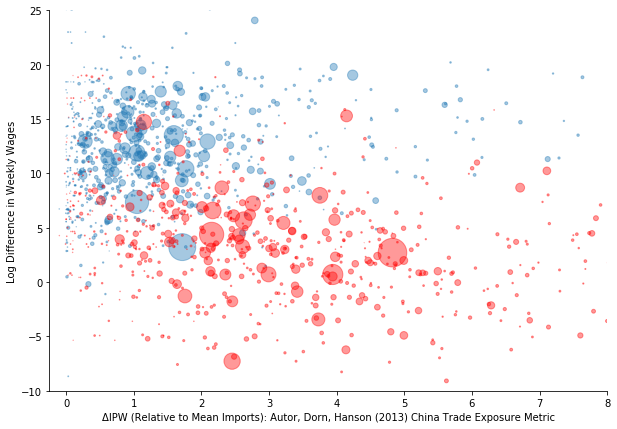

In [49]:
fig, ax = plt.subplots(figsize = (10,7))

year = "1990"

ax.scatter(df.set_index("yr").loc[int(year)].dm_IPW, #X variables
           df.set_index("yr").loc[int(year)].d_avg_lnwkwage,     # y variables 
            s = 0.00005*df.set_index("yr").loc[int(year)].l_popcount,
            alpha = 0.40) 

year = "2000"

ax.scatter(df.set_index("yr").loc[int(year)].dm_IPW, #X variables
           df.set_index("yr").loc[int(year)].d_avg_lnwkwage,     # y variables 
           s = 0.00005*df.set_index("yr").loc[int(year)].l_popcount,
            alpha = 0.40, color = "red") 

ax.set_ylabel("Log Difference in Weekly Wages") 
ax.set_xlabel("ΔIPW (Relative to Mean Imports): Autor, Dorn, Hanson (2013) China Trade Exposure Metric")

ax.set_xlim(-.25,8)
ax.set_ylim(-10,25)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

#plt.savefig(fig_path + "\\adh_data_wage_change.pdf", bbox_inches="tight", dpi = 1200)

plt.show()

This is quite interesting. What do I see:

- First you see how there is far more variation in trade exposure for the 2000s (red) periods vs. the 90s (blue). China came in and **fundamentally altered a commute zones exposure to trade by large amounts** 


- If you eye-ball this enough, for the 90s, **there is essentially zero correlation between wage growth and trade exposure during this time period.** If anything, it is slightly positive. But overall, it is mostly compressed between 0 and 1000 with lots of wage variation.


- If you look at the 2000s (red), two things are going on. First, wage growth is lower overall (shorter time period?) Second, there is **MAYBE** a "hockey stick" pattern between wage growth and trade exposure.


- Finally, a better characterization of the data is this (i) in 1990's, there is no relationship and (ii) in the 2000's the average growth rate of wages fell, but variance when up a bunch (and there is no relatioship wither within the 2000's). But what we have is two clusters: the 1990s with low exposure, high wages and then another cluster with high exposure, low wages. Then you get a negative slope? 

In [51]:
year = "1990"

reg_df = df.set_index("yr").loc[int(year)]
#reg_df = df

rhs_var = ["l_shind_manuf_cbp",
    "l_sh_popedu_c",
    "l_sh_popfborn",
    "l_sh_empl_f",
    "l_sh_routine33",
    "l_task_outsource"]


#reg_df = df.set_index("yr").loc[2000]


res_first = IV2SLS(reg_df.d_avg_lnwkwage, 
                   reg_df[["const"]+ rhs_var + regions + ["dm_IPW"]],
                   None, None,
                   weights = reg_df["timepwt48"]).fit(cov_type="clustered", clusters=reg_df["statefip"])

print(res_first)

                            OLS Estimation Summary                            
Dep. Variable:         d_avg_lnwkwage   R-squared:                      0.4752
Estimator:                        OLS   Adj. R-squared:                 0.4641
No. Observations:                 722   F-statistic:                    403.57
Date:                Fri, Mar 16 2018   P-value (F-stat)                0.0000
Time:                        11:57:44   Distribution:                 chi2(15)
Cov. Estimator:             clustered                                         
                                                                              
                                 Parameter Estimates                                 
                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------
const                -0.4202     5.9988    -0.0700     0.9442     -12.178      11.337
l_shind_manuf_cbp    -0.

In [72]:
rhs_var = ["l_shind_manuf_cbp",
    "l_sh_popedu_c",
    "l_sh_popfborn",
    "l_sh_empl_f",
    "l_sh_routine33",
    "l_task_outsource"]

###############################################################################
# this does it by decade...

year = [1990, 2000]

wage_elas = []

for item in year:
    
    reg_df = df.set_index("yr").loc[item]
    
    res_first = IV2SLS(reg_df.d_avg_lnwkwage, 
                   reg_df[["const"]+ rhs_var + regions],
                   reg_df.d_tradeusch_pw, 
                   reg_df.d_tradeotch_pw_lag,
                   weights = reg_df["timepwt48"]).fit(cov_type="clustered", clusters=reg_df["statefip"])
    
    wage_elas.append(res_first.params.d_tradeusch_pw)

###############################################################################
# Then this does the specification that will replicate ADH...

rhs_var.append("t2")

reg_df = df
    
res_first = IV2SLS(reg_df.d_avg_lnwkwage, 
                   reg_df[["const"]+ rhs_var + regions],
                   reg_df.d_tradeusch_pw, 
                   reg_df.d_tradeotch_pw_lag,
                   weights = reg_df["timepwt48"]).fit(cov_type="clustered", clusters=reg_df["statefip"])


print("Indivitual time periods 1990, then 2000   ", wage_elas)
print("ADH result (stacked time periods)   ", res_first.params.d_tradeusch_pw)


Indivitual time periods 1990, then 2000    [0.96646803771727718, -0.13451572726114591]
ADH result (stacked time periods)    -0.759216699971


This kind of confirms what is going on the figure above...two regions, one with high wage growth, low trade exposure. The other with low wage growth, high trade exposure. Within each region, there is an unclear relationship (1990s, positive insignificant), the (2000s, negative, insignificant). But then with the two together, it becomes strikingly negative and significant. 

One final point about this. The stuff below shows that essentially a time effect + region effect explains all the variation in wages, very little room for other things. 

In [80]:
rhs_var = []

rhs_var.append("t2")

res_first = IV2SLS(reg_df.d_avg_lnwkwage, 
                   reg_df[["const"]+ rhs_var + regions],
                   None, 
                   None,
                   weights = reg_df["timepwt48"]).fit(cov_type="clustered", clusters=reg_df["statefip"])

print(res_first)

                            OLS Estimation Summary                            
Dep. Variable:         d_avg_lnwkwage   R-squared:                      0.5241
Estimator:                        OLS   Adj. R-squared:                 0.5212
No. Observations:                1444   F-statistic:                    173.77
Date:                Fri, Mar 16 2018   P-value (F-stat)                0.0000
Time:                        14:22:45   Distribution:                  chi2(9)
Cov. Estimator:             clustered                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          12.962     0.7275     17.817     0.0000      11.536      14.388
t2            -8.5003     1.0096    -8.4193     0.00

---

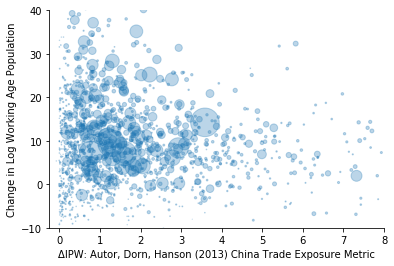

In [42]:
fig, ax = plt.subplots()

ax.scatter(df.d_tradeusch_pw, df.lnchg_popworkage,     # x,y variables 
            s = 0.00005*df.l_popcount,
            alpha = 0.30) # Then this last command specifies how dark or light the bubbles are...

#ax.set_title("Trade Exposure and Wage Growth")
ax.set_ylabel("Change in Log Working Age Population") 
ax.set_xlabel("ΔIPW: Autor, Dorn, Hanson (2013) China Trade Exposure Metric")

ax.set_xlim(-.25,8)
ax.set_ylim(-10,40)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

plt.savefig(fig_path + "\\adh_data_pop_change.pdf", bbox_inches="tight", dpi = 1200)

plt.show()

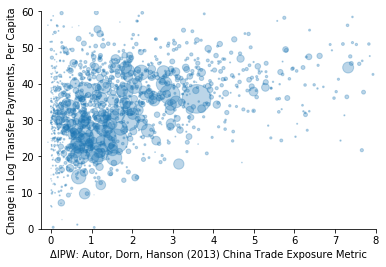

In [43]:
fig, ax = plt.subplots()

ax.scatter(df.d_tradeusch_pw, df.lnchg_trans_totindiv_pc,     # x,y variables 
            s = 0.00005*df.l_popcount,
            alpha = 0.30) # Then this last command specifies how dark or light the bubbles are...

#ax.set_title("Trade Exposure and Wage Growth")
ax.set_ylabel("Change in Log Transfer Payments, Per Capita") 
ax.set_xlabel("ΔIPW: Autor, Dorn, Hanson (2013) China Trade Exposure Metric")

ax.set_xlim(-.25,8)
ax.set_ylim(-0,60)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

plt.savefig(fig_path + "\\adh_data_trans_change.pdf", bbox_inches="tight", dpi = 1200)

plt.show()

**This is the Houshold income measure**

In [ ]:
fig_path = "C:\\Users\\mwaugh.NYC-STERN\\Documents\\GitHub\\tradeexposure\\figures"

fig, ax = plt.subplots()

ax.scatter(df.d_tradeusch_pw, relchg_avg_hhincsum_pc_pw,     # x,y variables 
            s = 0.00005*df.l_popcount,
            alpha = 0.30) # Then this last command specifies how dark or light the bubbles are...

#ax.set_title("Trade Exposure and Wage Growth")
ax.set_ylabel("Log Change in Average Weekly Wages") 
ax.set_xlabel("IPW: Autor, Dorn, Hanson (2013) China Trade Exposure Metric")

ax.set_xlim(-.25,8)
ax.set_ylim(-20,35)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

#plt.savefig(fig_path + "\\adh_data.pdf", bbox_inches="tight", dpi = 1200)

plt.show()

In [46]:
rhs_var = ["l_shind_manuf_cbp",
    "l_sh_popedu_c",
    "l_sh_popfborn",
    "l_sh_empl_f",
    "l_sh_routine33",
    "l_task_outsource", "t2"]


res_first = IV2SLS(df.lnchg_popworkage, df[["const"] + rhs_var+ regions+ ["d_tradeusch_pw"]], 
                   None, None, 
                   weights = df["timepwt48"]).fit(cov_type='unadjusted')

print(res_first)

                            OLS Estimation Summary                            
Dep. Variable:       lnchg_popworkage   R-squared:                      0.4250
Estimator:                        OLS   Adj. R-squared:                 0.4185
No. Observations:                1444   F-statistic:                    1067.3
Date:                Thu, Mar 15 2018   P-value (F-stat)                0.0000
Time:                        14:16:15   Distribution:                 chi2(16)
Cov. Estimator:            unadjusted                                         
                                                                              
                                 Parameter Estimates                                 
                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------
const                 1.1659     5.4564     0.2137     0.8308     -9.5284      11.860
l_shind_manuf_cbp    -0.

In [28]:
res_first = IV2SLS(df.lnchg_popworkage, df[["const"]+ rhs_var + regions], 
                   df.d_tradeusch_pw, df.d_tradeotch_pw_lag, 
                   weights = df["timepwt48"]).fit(cov_type='unadjusted')

print(res_first)

                          IV-2SLS Estimation Summary                          
Dep. Variable:       lnchg_popworkage   R-squared:                      0.4234
Estimator:                    IV-2SLS   Adj. R-squared:                 0.4169
No. Observations:                1444   F-statistic:                    1061.5
Date:                Sat, Mar 10 2018   P-value (F-stat)                0.0000
Time:                        08:48:41   Distribution:                 chi2(16)
Cov. Estimator:            unadjusted                                         
                                                                              
                                 Parameter Estimates                                 
                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------
const                 1.2356     5.4644     0.2261     0.8211     -9.4745      11.946
l_shind_manuf_cbp    -0.

In [16]:
just1990 = df.set_index("yr").loc[1990]

res_first = IV2SLS(just1990.d_avg_lnwkwage, 
                   just1990[["const"]], 
                   just1990.dm_IPW, just1990.d_tradeotch_pw_lag,
                   weights = just1990["timepwt48"]).fit(cov_type='unadjusted')

print(res_first)

                          IV-2SLS Estimation Summary                          
Dep. Variable:         d_avg_lnwkwage   R-squared:                      0.0008
Estimator:                    IV-2SLS   Adj. R-squared:                -0.0006
No. Observations:                 722   F-statistic:                    0.0063
Date:                Thu, Mar 01 2018   P-value (F-stat)                0.9370
Time:                        16:17:57   Distribution:                  chi2(1)
Cov. Estimator:            unadjusted                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          11.866     0.3043     38.987     0.0000      11.269      12.462
dm_IPW         0.0136     0.1717     0.0791     0.93